In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Found 4 point clusters.


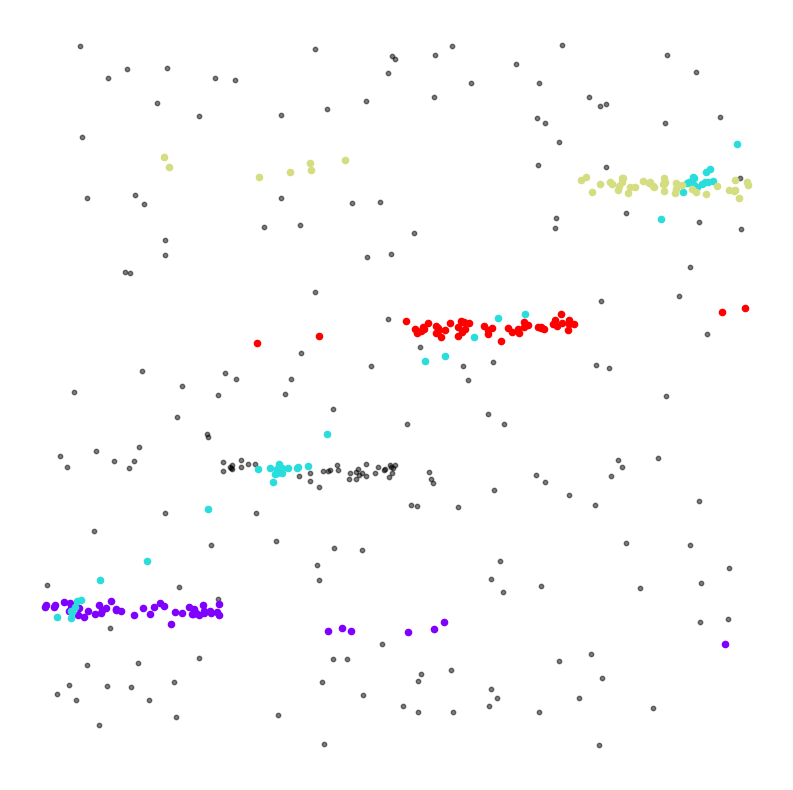

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def load_and_plot(points_file, lines_file):
    # 1. Load Data
    try:
        df_points = pd.read_csv(points_file)
        df_lines = pd.read_csv(lines_file)
    except Exception as e:
        print(f"Error loading files: {e}")
        return

    # Setup the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    bg_color = 'white'
    fig.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # 2. Handle Noise (cluster_id == -1)
    noise = df_points[df_points['cluster_id'] == -1]
    if not noise.empty:
        ax.scatter(noise['x0'], noise['x1'], c='black', s=10, alpha=0.5, zorder=1)

    # 3. Process "Signal" Clusters
    signal_points = df_points[df_points['cluster_id'] != -1]
    point_cluster_ids = signal_points['cluster_id'].unique()

    # Generate a color map
    colors = cm.rainbow(np.linspace(0, 1, len(point_cluster_ids)))

    print(f"Found {len(point_cluster_ids)} point clusters.")

    for pid, color in zip(point_cluster_ids, colors):
        cluster_data = signal_points[signal_points['cluster_id'] == pid]
        points_xy = cluster_data[['x0', 'x1']].values

        # --- FIXED LOGIC: MATCH BY ID INSTEAD OF DISTANCE ---

        # Filter the lines dataframe for the specific cluster ID
        matching_line_row = df_lines[df_lines['cluster_id'] == pid]

        # Only proceed if we actually found a matching line row
        if not matching_line_row.empty:
            # Extract the single row
            line_row = matching_line_row.iloc[0]

            x_m = np.array([line_row['x_m_0'], line_row['x_m_1']])
            b_new = np.array([line_row['b_new_0'], line_row['b_new_1']])

            # Calculate direction
            norm_b = np.linalg.norm(b_new)
            if norm_b == 0:
                print(f"Warning: Zero normal vector for Cluster {pid}")
                # Still plot points even if line fails
                ax.scatter(points_xy[:, 0], points_xy[:, 1], color=color, s=20, zorder=2)
                continue

            direction = np.array([-b_new[1], b_new[0]])
            direction = direction / np.linalg.norm(direction)

            # Project points to find start/end of line segment
            vecs_from_xm = points_xy - x_m
            projections = np.dot(vecs_from_xm, direction)

            t_min, t_max = projections.min(), projections.max()
            padding = (t_max - t_min) * 0.1
            t_min -= padding
            t_max += padding

            p_start = x_m + t_min * direction
            p_end = x_m + t_max * direction

            # Plot the Points
            ax.scatter(points_xy[:, 0], points_xy[:, 1], color=color, s=20, zorder=2)

            # Plot the Line Segment
            ax.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]],
                     color='black', linewidth=1.5, linestyle='-', zorder=3)

        else:
            # If no line exists in the CSV for this cluster ID
            print(f"Warning: No line data found in CSV for Cluster ID {pid}")
            # Plot points anyway so you can see them
            ax.scatter(points_xy[:, 0], points_xy[:, 1], color=color, s=20, zorder=2)

    # --- Minimalist Styling ---
    ax.grid(True, color='black', alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig('test.png')
    plt.show()

# --- Usage ---
points_filename = 'runs/run_4/clustered_data_experiment2.csv'
lines_filename = 'runs/run_4/mean_qdf_experiment2.csv'

load_and_plot(points_filename, lines_filename)

Re-assigning points for visualization...


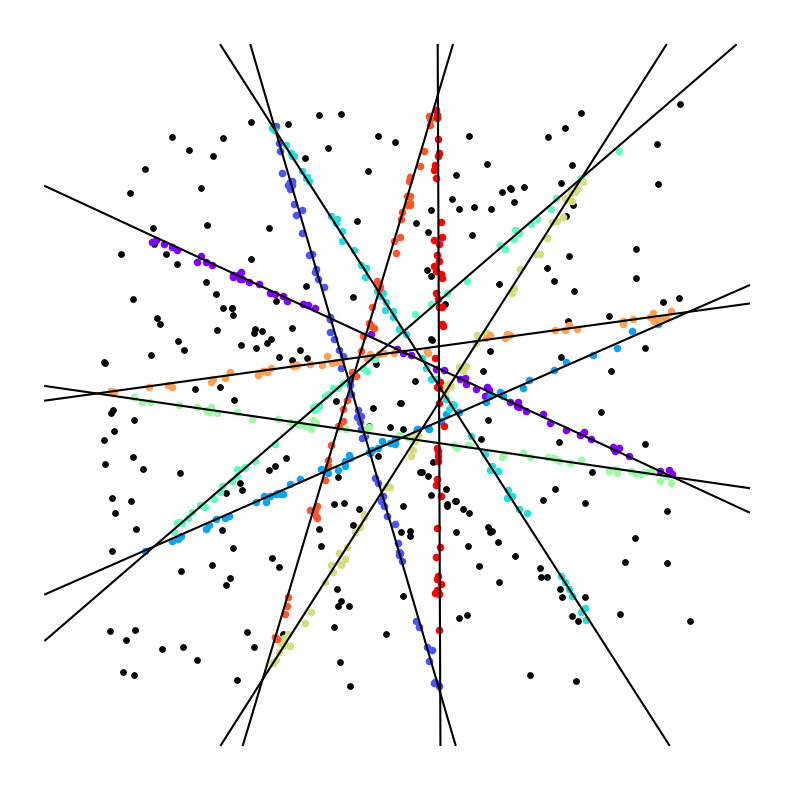

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def point_line_distance(px, py, origin, direction):
    """
    Calculates perpendicular distance from point (px, py) to line defined by origin and direction.
    """
    # Vector from line origin to point
    w = np.array([px - origin[0], py - origin[1]])

    # Projection of w onto direction (which must be normalized)
    proj_dist = np.dot(w, direction)

    # Perpendicular vector component
    perp_vec = w - proj_dist * direction

    # Norm of perpendicular vector is the distance
    return np.linalg.norm(perp_vec)

def reassign_points_to_lines(df_points, df_lines, threshold=0.1):
    """
    Re-assigns every point to the closest line if it is within 'threshold'.
    Returns a new dataframe with updated 'assigned_id'.
    """
    # Extract line data for fast access
    lines_data = []
    for idx, row in df_lines.iterrows():
        origin = np.array([row['ox'], row['oy']])
        direction = np.array([row['bx'], row['by']])
        norm = np.linalg.norm(direction)
        if norm > 0:
            direction /= norm
        lines_data.append({
            'id': row['cluster_id'],
            'origin': origin,
            'dir': direction
        })

    # Function to apply to each point
    def get_best_cluster(row):
        p_x, p_y = row['x0'], row['x1']
        best_dist = float('inf')
        best_id = -1

        for line in lines_data:
            d = point_line_distance(p_x, p_y, line['origin'], line['dir'])
            if d < best_dist:
                best_dist = d
                best_id = line['id']

        # Only assign if within threshold
        if best_dist <= threshold:
            return best_id
        else:
            return -1

    # Create a copy and apply reassignment
    new_df = df_points.copy()
    new_df['plot_id'] = new_df.apply(get_best_cluster, axis=1)
    return new_df

def clip_line_to_bbox(origin, direction, bbox):
    t_enter, t_exit = -np.inf, np.inf

    # Check X planes
    if direction[0] == 0:
        if origin[0] < bbox[0] or origin[0] > bbox[1]: return None, None
    else:
        t0, t1 = (bbox[0] - origin[0]) / direction[0], (bbox[1] - origin[0]) / direction[0]
        t_enter = max(t_enter, min(t0, t1))
        t_exit = min(t_exit, max(t0, t1))

    # Check Y planes
    if direction[1] == 0:
        if origin[1] < bbox[2] or origin[1] > bbox[3]: return None, None
    else:
        t0, t1 = (bbox[2] - origin[1]) / direction[1], (bbox[3] - origin[1]) / direction[1]
        t_enter = max(t_enter, min(t0, t1))
        t_exit = min(t_exit, max(t0, t1))

    if t_enter > t_exit: return None, None
    return origin + t_enter * direction, origin + t_exit * direction

def load_and_plot(points_file, lines_file, reassign_threshold=0.1):
    try:
        # Load Data
        df_points = pd.read_csv(points_file)
        df_lines = pd.read_csv(lines_file, header=None,
                               names=['cluster_id', 'ox', 'oy', 'rank', 'bx', 'by'])

        print("Re-assigning points for visualization...")
        # Override the CSV cluster_ids with our own distance check
        df_points = reassign_points_to_lines(df_points, df_lines, threshold=reassign_threshold)

    except Exception as e:
        print(f"Error: {e}")
        return

    # Setup Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.set_facecolor('white')
    ax.set_facecolor('white')

    # Bounding box
    all_x, all_y = df_points['x0'], df_points['x1']
    margin = 0.2
    bbox = [all_x.min()-margin, all_x.max()+margin, all_y.min()-margin, all_y.max()+margin]

    # Plot Noise (points that remained -1 after reassignment)
    noise = df_points[df_points['plot_id'] == -1]
    if not noise.empty:
        ax.scatter(noise['x0'], noise['x1'], c='black', s=15, alpha=1, label='Noise')

    # Plot Clusters and Lines
    line_ids = df_lines['cluster_id'].unique()
    colors = cm.rainbow(np.linspace(0, 1, len(line_ids)))

    for pid, color in zip(line_ids, colors):
        # 1. Plot Points for this Line
        cluster_points = df_points[df_points['plot_id'] == pid]

        if not cluster_points.empty:
            pts = cluster_points[['x0', 'x1']].values
            ax.scatter(pts[:, 0], pts[:, 1], color=color, s=20, zorder=2)

        # 2. Draw the Line
        line_row = df_lines[df_lines['cluster_id'] == pid].iloc[0]
        origin = np.array([line_row['ox'], line_row['oy']])
        direction = np.array([line_row['bx'], line_row['by']])
        direction /= np.linalg.norm(direction)

        # Clip line to view area
        p_start, p_end = clip_line_to_bbox(origin, direction, bbox)

        if p_start is not None:
            ax.plot([p_start[0], p_end[0]], [p_start[1], p_end[1]],
                    color='black', linewidth=1.5, linestyle='-', zorder=3)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('star11_greedy_worst.png', dpi=300)
    plt.show()

# --- Usage ---
# Increase 'reassign_threshold' if points are still grey!
load_and_plot(
    'runs/run_1/clustered_data_experiment2.csv',
    'runs/run_1/detected_subspaces_experiment2.csv',
    reassign_threshold=0.02  # <--- I increased this to catch the points
)